### Create Synthetic Datasets
---

This notebook is used to generate simple sinusoidal synthetic datasets with a specified numbers of worms, named neurons, and other characteristics of real datasets.

*Last update: 3 November 2023*

#### Libraries and helper functions
---

In [252]:
!pip install -q statsmodels

import torch
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import NEURONS_302
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data

In [253]:
def plot_signals(data, time_tensor, neuron_idx=None, yax_limit=True, suptitle=None):
    assert isinstance(data, torch.Tensor), "data must be a PyTorch tensor"
    assert isinstance(time_tensor, torch.Tensor), "time_tensor must be a PyTorch tensor"
    assert data.dim() == 2, "data must be a 2D tensor"
    assert isinstance(neuron_idx, (int, list)), "neuron_idx must be an integer or list"

    time_tensor = time_tensor.squeeze()
    assert data.size(0) == time_tensor.size(
        0
    ), "Number of rows in data and time_tensor must match"

    num_neurons = data.size(1)

    # Randomly select the column indices if not provided
    if isinstance(neuron_idx, int):
        assert (
            neuron_idx <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.random.choice(num_neurons, neuron_idx, replace=False)
    elif isinstance(neuron_idx, list):
        assert (
            len(neuron_idx) <= num_neurons
        ), "neuron_idx cannot exceed the number of neurons"
        column_indices = np.array(neuron_idx)

    num_columns = len(column_indices)

    # Extract the selected columns from the data tensor
    selected_columns = data[:, column_indices]

    # Define the color palette using scientific colors
    colors = sns.color_palette("bright", num_columns)

    # Plotting subplots vertically
    fig, axs = plt.subplots(num_columns, 1, figsize=(15, num_columns))
    fig.tight_layout(pad=0.0)

    for i, ax in enumerate(axs):
        ax.plot(time_tensor, selected_columns[:, i], color=colors[i])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.yaxis.set_ticks_position("none")
        if yax_limit:
            ax.set_ylim(-1.0, 1.0)
        ax.set_ylabel("{}".format(NEURONS_302[column_indices[i]]))

        if i < num_columns - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel("Time (s)")

    # Add a super title to the figure if provided
    if suptitle is not None:
        fig.suptitle(suptitle, fontsize=16)

    plt.tight_layout(pad=1)

    plt.show()

In [254]:
def plot_3d_trajectory(
    X, axis_labels=("X Axis", "Y Axis", "Z Axis"), title="3D Trajectory", show=True
):
    """
    Plot a 3D trajectory from a dataset.

    Parameters:
    - X: A 2D numpy array of shape (max_timesteps, 3) containing the trajectory data.
    - axis_labels: A tuple containing the labels for the axes. Default is ('X Axis', 'Y Axis', 'Z Axis').
    - title: Title of the plot.
    - show: If True, the plot will be displayed. If False, the plot object will be returned.

    Returns:
    - fig, ax: The figure and axis objects of the plot if show is False.
    """
    max_timesteps = X.shape[0]

    # Create a new figure for the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Extract x, y, z coordinates from the data
    x, y, z = X[:, 0], X[:, 1], X[:, 2]

    # Create a color map based on the time progression
    norm = plt.Normalize(0, max_timesteps)
    colors = plt.cm.viridis(norm(np.arange(max_timesteps)))

    # Plot the 3D trajectory with a color gradient
    for i in range(1, len(x)):
        ax.plot(
            x[i - 1 : i + 1],
            y[i - 1 : i + 1],
            z[i - 1 : i + 1],
            color=colors[i],
            lw=0.5,
        )

    # Mark the start of the trajectory with a green star
    ax.plot([x[0]], [y[0]], [z[0]], "g*", markersize=8)

    # Mark the end of the trajectory with a red circle
    ax.plot([x[-1]], [y[-1]], [z[-1]], "ro", markersize=7)

    # Set labels for the axes
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_zlabel(axis_labels[2])

    # Set title
    ax.set_title(title)

    # Show the plot
    if show:
        plt.show()
    else:
        return fig, ax

In [255]:
def time_delay_embedding(x, delay, dimension):
    """
    Constructs a time-delay embedding matrix from time series data.

    :param x: Time series data as a 1D numpy array.
    :param delay: The delay \(\tau\) between time series elements in the embedding.
    :param dimension: The embedding dimension \(m\).
    :return: The time-delay embedded data as a 2D numpy array.
    """
    n = len(x)
    if n < (dimension - 1) * delay + 1:
        raise ValueError(
            "Time series data is too short for the given delay and dimension."
        )
    m = n - (dimension - 1) * delay
    embedded_data = np.empty((m, dimension))
    for i in range(m):
        for j in range(dimension):
            embedded_data[i, j] = x[i + j * delay]
    return embedded_data

In [256]:
def lorenz(X, t, sigma=10.0, beta=8.0 / 3, rho=28.0):
    """The Lorenz equations."""
    x, y, z = X
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    return [dx_dt, dy_dt, dz_dt]

In [257]:
def save_synthetic_dataset(file_name, dataset):
    with open(file_name, "wb") as f:
        pickle.dump(dataset, f)

#### Sines dataset
---

In [258]:
def create_synthetic_dataset_sines(
    max_timesteps=1000,
    num_worms=1,
    num_signals=302,
    num_named_neurons=1,
    add_noise=False,
    noise_std=0.01,
    random_walk=False,
    sum_frequencies=1,
    random_freqs=False,
    delta_seconds=0.7,
    smooth_method="GA",
    transform=StandardScaler(),
    dataset_name="Sines0000",
):
    """
    Create a synthetic worm datasets using a sum of sinusoidal functions.
    Out of the `num_signals` neurons, `num_named_neurons` neurons are chosen randomly
    to have non-zero (i.e. "measured") signals. Each neuron's calcium signal is a sinusoid
    with `sum_frequencies` frequencies added together and a random phase.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signals: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param add_noise: If True, add zero-mean Gaussian noise to the synthetic data. Otherwise, do not add noise.
    :param noise_std: The standard deviation of the additive Gaussian noise if add_noise is True.
    :param random_walk: If True, use a random walk to generate the noise. Otherwise, use iid noise.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param random_freqs: If True, use random frequencies for each neuron. Otherwise, use the same frequencies for all neurons.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: Standard deviation of the Gaussian noise.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Calculation of unknown neurons
    num_unknown_neurons = num_signals - num_named_neurons

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            neuron_name = NEURONS_302[i]

            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                np.clip(
                    np.round(np.random.random(sum_frequencies) / 10, 2), 0, 0.1
                ).tolist()  # random frequencies
                if random_freqs
                else np.clip(
                    np.round(np.arange(sum_frequencies + 1) / 100, 2), 0, 0.1
                ).tolist(),  # deterministic frequencies
            )

            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    for _ in range(sum_frequencies)
                ],
            )

            time_points = np.arange(max_timesteps)

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if add_noise:
                if random_walk:
                    noise_walk = np.cumsum(
                        [0]
                        + np.random.normal(
                            loc=0, scale=noise_std, size=max_timesteps - 1
                        ).tolist()
                    )
                    calcium_data[:, i] += noise_walk
                else:
                    noise_iid = np.random.normal(0, noise_std, max_timesteps)
                    calcium_data[:, i] += noise_iid

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        if smooth_method is not None:
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
        else:
            smooth_calcium_data = calcium_data
            smooth_residual_calcium = residual_calcium

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [259]:
# Initialize parameters
max_timesteps = 3000
num_worms = 1
num_named_neurons = 5
add_noise = True
noise_std = 0.1
random_walk = True
file_name = "Sines0000"
sum_frequencies = 1
random_freqs = False
delta_seconds = 0.5
smooth_method = None  # "GA"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=302,
    num_named_neurons=num_named_neurons,
    add_noise=add_noise,
    noise_std=noise_std,
    random_walk=random_walk,
    sum_frequencies=sum_frequencies,
    random_freqs=random_freqs,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=StandardScaler(),
    dataset_name=file_name,
)

# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    :num_named_neurons
]

# Save the dataset
save_synthetic_dataset(f"processed/neural/{file_name}.pickle", dataset)

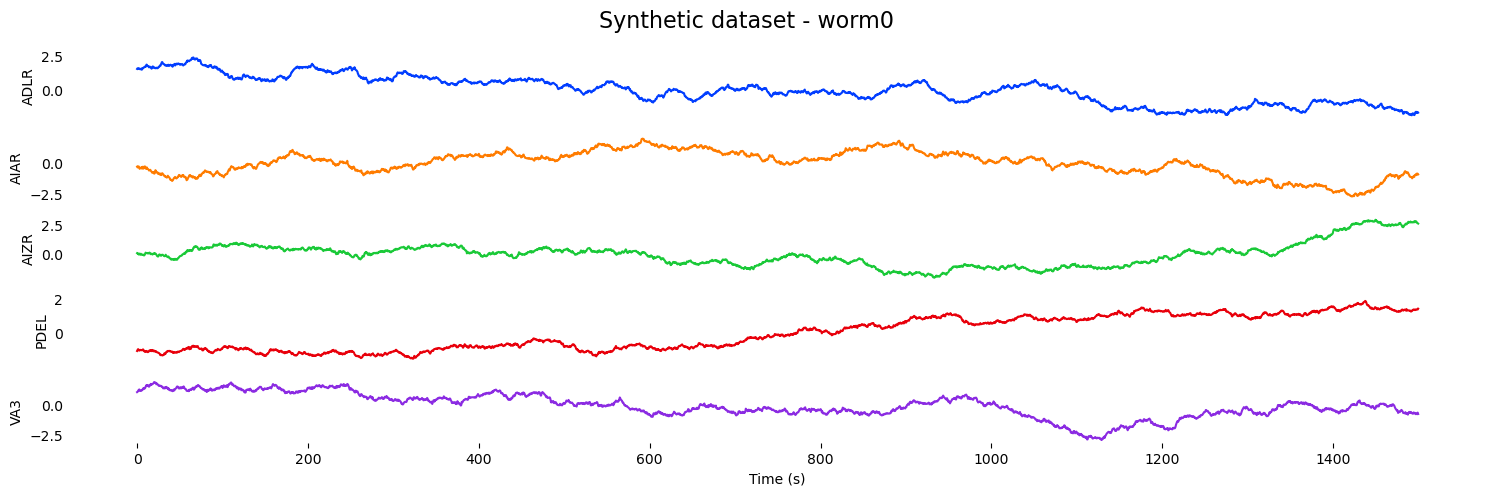

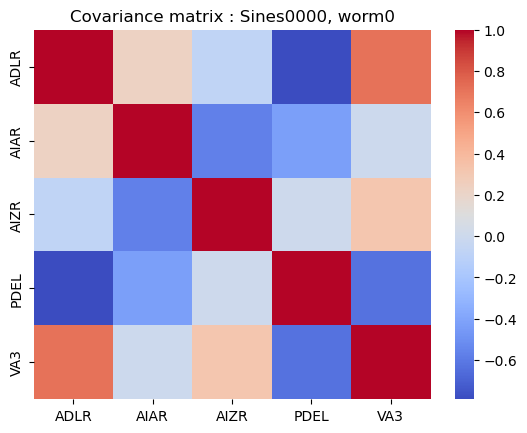

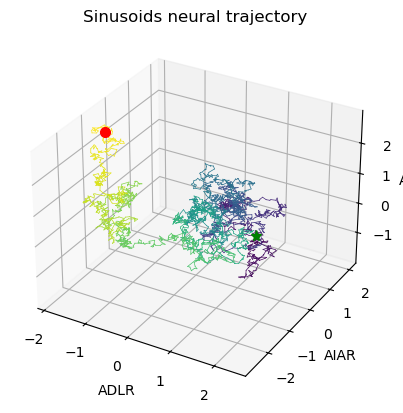

In [260]:
# Plotting dataset
plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Visualize covariance matrix
data = dataset[worm_idx]["smooth_calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {file_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(
    X, axis_labels=tuple(neurons[:3]), title="Sinusoids neural trajectory"
)

#### Autocorrelation
---
Autocorrelation and partial autocorrelation are concepts used in time series analysis to examine the relationship of a variable with itself at different lags.

**Autocorrelation Function (ACF):**
- This is a correlation of a signal with a delayed copy of itself as a function of delay.
- The autocorrelation plot (or ACF plot) displays the correlation between the time series and its lagged values.
- The y-axis shows the autocorrelation coefficient, which ranges from -1 to 1. A value of 1 indicates perfect positive correlation, while -1 indicates perfect negative correlation.
- The x-axis represents the lag at which the autocorrelation is computed. For example, at lag 1, you're comparing the series with itself one time step back.
- The ACF considers the combined effect of all previous time points up to the lagged time point being calculated. It doesn't isolate the correlation at each lag.

**Partial Autocorrelation Function (PACF):**
- This measures the correlation between the time series and its lagged version after accounting for the variations already explained by the intervening comparisons. In other words, it controls for the previous lags.
- The PACF plot shows the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags.
- It isolates the additional correlation at a particular lag that is not explained by previous lags. This is useful to identify the actual lagged relationship, without the confounding effects of the correlations at shorter lags.

In summary, while the ACF shows the cumulative effect of past data points on the current value, the PACF removes this cumulative effect and tries to show the unique contribution of each past data point.

In practical applications like ARIMA (AutoRegressive Integrated Moving Average) modeling, the ACF and PACF are used to determine the AR (autoregressive) and MA (moving average) terms:

* The PACF helps to identify the order of the AR part (p) by finding the lag after which the PACF cuts off (drops to zero or below the significance level).
* The ACF is used to identify the order of the MA part (q) by finding the lag after which the ACF cuts off.





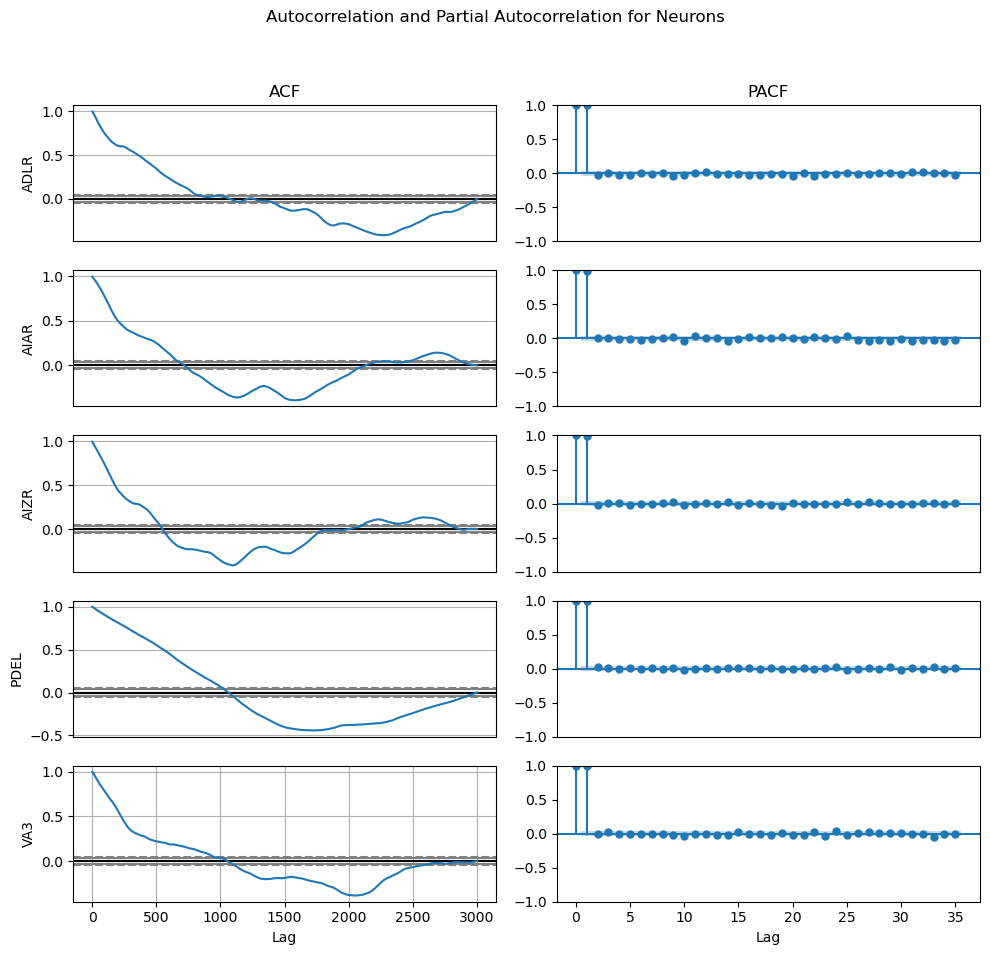

In [261]:
# Assuming `neurons` is a list of neuron names
num_neurons = X.shape[1]

# Create a figure and an array of subplots with 2 columns
fig, axes = plt.subplots(nrows=num_neurons, ncols=2, figsize=(10, 2 * num_neurons))

# Set a suptitle for the entire figure
fig.suptitle("Autocorrelation and Partial Autocorrelation for Neurons")

# Iterate over the number of neurons to create individual plots
for i in range(num_neurons):
    # Plot ACF on the left column (0th index)
    ax_left = axes[i, 0] if num_neurons > 1 else axes[0]
    autocorrelation_plot(X[:, i], ax=ax_left)
    ax_left.set_title("ACF" if i == 0 else "")  # Title for first plot only
    ax_left.set_xlabel("")  # Remove individual x labels
    ax_left.set_ylabel(neurons[i])  # Set neuron name as y label

    # Remove xticks except for the bottom plot
    if i < num_neurons - 1:
        ax_left.set_xticklabels([])
        ax_left.set_xticks([])

    # Plot PACF on the right column (1st index)
    ax_right = axes[i, 1] if num_neurons > 1 else axes[1]
    plot_pacf(X[:, i], ax=ax_right)
    ax_right.set_title("PACF" if i == 0 else "")  # Title for first plot only
    ax_right.set_xlabel("")  # Remove individual x labels
    ax_right.set_ylabel("")  # Remove y labels from the right column

    # Remove xticks except for the bottom plot
    if i < num_neurons - 1:
        ax_right.set_xticklabels([])
        ax_right.set_xticks([])

# Set x-axis labels for the bottom plots
axes[-1, 0].set_xlabel("Lag")
axes[-1, 1].set_xlabel("Lag")

# Adjust the layout to not overlap plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plots
plt.show()

#### Lorenz dataset
---

In [262]:
def create_synthetic_dataset_lorenz(
    max_timesteps=1000,
    num_worms=1,
    num_signals=302,
    add_noise=False,
    noise_std=0.01,
    num_lorenz_systems=1,
    fine_integration_step=0.1,
    delta_seconds=0.7,
    smooth_method="GA",
    transform=StandardScaler(),
    dataset_name="Lorenz0000",
):
    """
    Create a synthetic worm datasets using the Lorenz attractor.
    Three neurons are chosen randomly to represent x, y, z trajectories from the Lorenz system.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signals: The number of signals, corresponds to number of neurons.
    :param add_noise: If True, add Gaussian noise to the synthetic data.
    :param noise_std: The sklearn transform to use for normalizing the data.
    :param num_lorenz_systems: The number of Lorenz systems to use for creating the synthetic data.
    :param fine_integration_step: The integration step size for the Lorenz system.
    :param delta_seconds: The constant time difference (in seconds) between each measurement of the system.
    :param smooth_method: The method to use for smoothing the data.
    :param transform: Standard deviation of the Gaussian noise.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Calculation of named and unknown neurons
    num_named_neurons = num_lorenz_systems * 3
    num_unknown_neurons = num_signals - num_named_neurons

    # Fine integration time points
    fine_time_points = np.arange(
        0, max_timesteps * delta_seconds, fine_integration_step
    )

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, num_signals))
        named_neuron_indices = random.sample(
            range(num_signals), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        calcium_data = np.zeros((max_timesteps, num_signals))

        # Create multiple Lorenz systems
        for system_idx in range(num_lorenz_systems):
            # Define a new set of initial conditions for each Lorenz system
            system_initial_conditions = np.random.rand(
                3
            )  # or other method to generate initial conditions

            # Integrate the Lorenz system
            fine_trajectories = odeint(
                lorenz, system_initial_conditions, fine_time_points
            )

            # Downsampling to get the sampled data at delta_seconds intervals
            downsample_indices = np.arange(
                0, len(fine_time_points), int(delta_seconds / fine_integration_step)
            )

            # Downsample and assign to neurons as before
            sampled_trajectories = fine_trajectories[downsample_indices]

            # Assign to the correct set of neurons for this Lorenz system
            for i in range(3):
                neuron_index = named_neuron_indices[system_idx * 3 + i]
                calcium_data[:, neuron_index] = sampled_trajectories[:, i]

                # Optionally add noise
                if add_noise:
                    calcium_data[:, neuron_index] += np.random.normal(
                        0, noise_std, max_timesteps
                    )

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Calculate residuals
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        resample_dt = np.round(np.median(dt).item(), 2)
        residual_calcium = np.gradient(calcium_data, axis=0) / dt

        # Smooth the data
        if smooth_method is not None:
            smooth_calcium_data = smooth_data_preprocess(
                calcium_data, time_in_seconds, smooth_method
            )
            smooth_residual_calcium = smooth_data_preprocess(
                residual_calcium, time_in_seconds, smooth_method
            )
        else:
            smooth_calcium_data = calcium_data
            smooth_residual_calcium = residual_calcium

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["max_timesteps"] = max_timesteps
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signals
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        # Reshape the data to the standardized format
        worm_data = reshape_calcium_data(worm_data)

        # Save the data
        dataset[worm] = worm_data

    return dataset

In [263]:
# Initialize parameters
max_timesteps = 3000
num_worms = 1
add_noise = False
noise_std = 0.1
num_lorenz_systems = 1
fine_integration_step = 0.01
file_name = "Lorenz0000"
delta_seconds = 0.05
smooth_method = None  # "GA"

# Creating and saving datasets
dataset = create_synthetic_dataset_lorenz(
    max_timesteps=max_timesteps,
    num_worms=num_worms,
    num_signals=302,
    add_noise=add_noise,
    noise_std=noise_std,
    num_lorenz_systems=num_lorenz_systems,
    fine_integration_step=fine_integration_step,
    delta_seconds=delta_seconds,
    smooth_method=smooth_method,
    transform=StandardScaler(),
    dataset_name=file_name,
)

# Selecting a worm and all the neurons to plot
worm_idx = random.choice([f"worm{i}" for i in range(num_worms)])
neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()][
    : num_lorenz_systems * 3
]

# Save the dataset
save_synthetic_dataset(f"processed/neural/{file_name}.pickle", dataset)

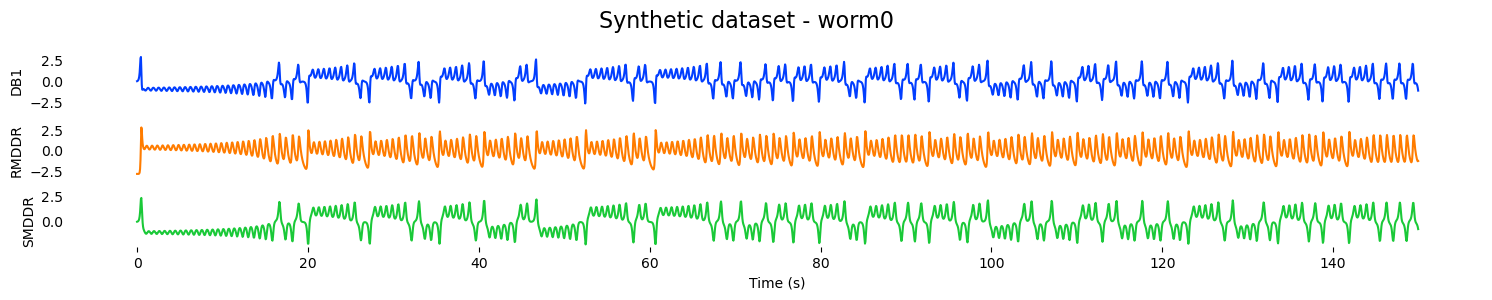

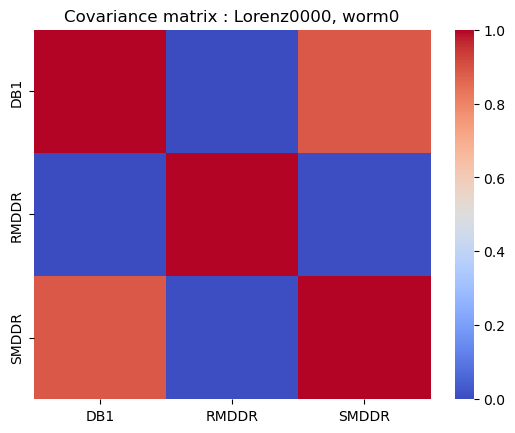

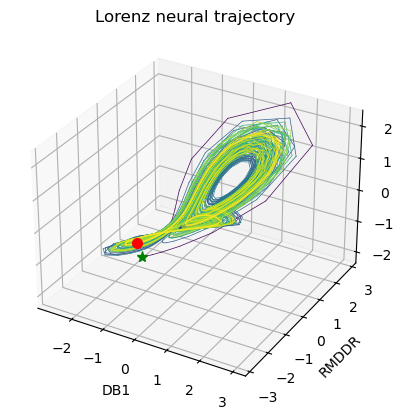

In [264]:
# Plotting dataset
plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Visualize covariance matrix
data = dataset[worm_idx]["smooth_calcium_data"]
mask = dataset[worm_idx]["named_neurons_mask"]
neurons = sorted(dataset[worm_idx]["named_neuron_to_slot"])

X = data[:, mask].numpy()
n = X.shape[0]
X_bar = X - np.mean(X, axis=0)
cov = 1 / (n - 1) * X_bar.T @ X_bar

plt.figure()
ax = sns.heatmap(cov, cmap="coolwarm", xticklabels=neurons, yticklabels=neurons)
ax.set_title(f"Covariance matrix : {file_name}, {worm_idx}")
plt.show()

# Plotting 3D trajectory
plot_3d_trajectory(X, axis_labels=tuple(neurons), title="Lorenz neural trajectory")

#### Time Delay Embedding
---
Time delay embedding is a technique used in the analysis of dynamical systems, particularly in the context of reconstructing the phase space of a system from a series of observations over time. This technique is based on Takens' Embedding Theorem, which states that the dynamics of a system can be reconstructed from the time series of a single observable of the system, under certain conditions.

Here are some key points about time delay embedding:

- **Time Delay, τ (tau):** This is the time interval between successive observations in the reconstructed phase space. Choosing an appropriate τ is crucial; too short a delay may lead to redundant information, while too long a delay may lose the dynamics of interest.

- **Embedding Dimension, m:** This represents the number of delayed observations used to reconstruct the phase space. It should be high enough to unfold the dynamics, but not too high to avoid overcomplicating the model.

- **Phase Space Reconstruction:** By plotting the time-delayed copies of the time series against each other, one can reconstruct the phase space, which can reveal underlying dynamical properties like attractors or limit cycles.

- **Mutual Information:** To empirically choose the right τ, one common method is to calculate the mutual information between the time series and its delayed version, and select τ at the first minimum of the mutual information function.

- **False Nearest Neighbors (FNN):** The method of False Nearest Neighbors can help determine a suitable embedding dimension m by identifying when points that appear to be neighbors in lower-dimensional space are no longer neighbors in higher dimensions.


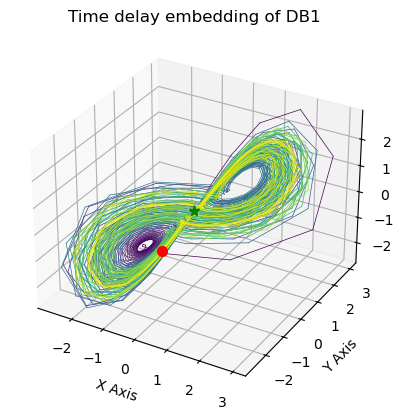

In [265]:
# Example usage:
# Let's assume you have a time series data stored in a variable called `time_series_data`.
idx = 0
time_series_data = X[:, idx]
# You would first determine `tau` and `m` based on your data.

tau = 1  # replace with the delay you've computed or chosen
m = 3  # replace with the embedding dimension you've computed or chosen

# You can then compute the time-delay embedding of your data as follows:
embedded_data = time_delay_embedding(time_series_data, tau, m)
plot_3d_trajectory(embedded_data, title=f"Time delay embedding of {neurons[idx]}")

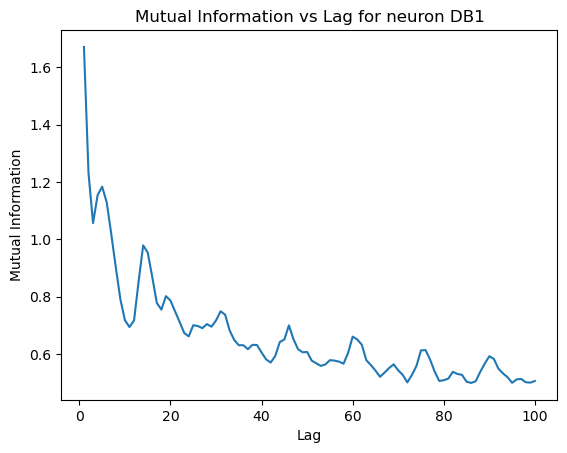

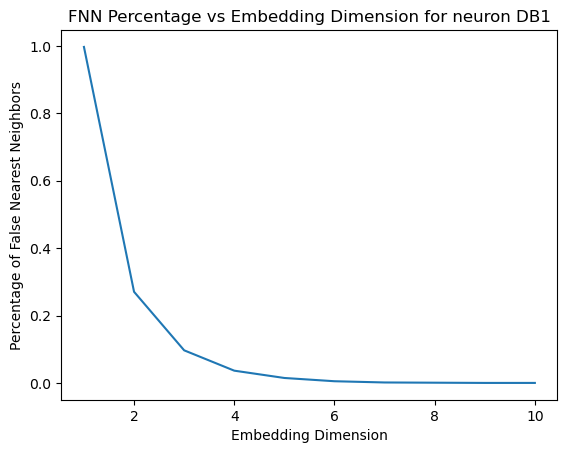

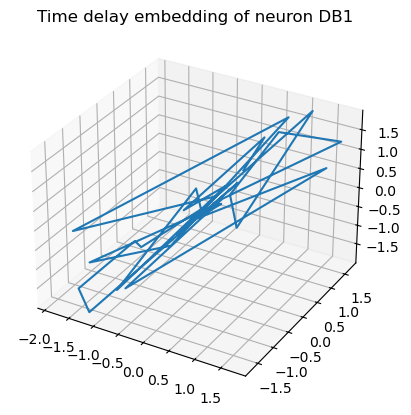

In [275]:
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt


def mutual_information(time_series, max_lag):
    """
    Estimate mutual information for a range of lags in the time_series.
    """
    mi = []
    bins = np.sqrt(len(time_series)).astype(int)  # Rule-of-thumb for number of bins

    for lag in range(1, max_lag + 1):
        # Create a 2D histogram
        counts_xy, _, _ = np.histogram2d(
            time_series[:-lag], time_series[lag:], bins=bins
        )

        # Convert counts to probabilities
        p_xy = counts_xy / float(np.sum(counts_xy))
        p_x = p_xy.sum(axis=1)  # Marginal for x over y
        p_y = p_xy.sum(axis=0)  # Marginal for y over x

        # Compute the mutual information
        # Get the indices of non-zero probabilities
        non_zero_idx = np.nonzero(p_xy)

        # Index the marginal probabilities with the non-zero indices to ensure correct shapes
        mi_lag = np.sum(
            p_xy[non_zero_idx]
            * np.log(p_xy[non_zero_idx] / (p_x[non_zero_idx[0]] * p_y[non_zero_idx[1]]))
        )

        mi.append(mi_lag)

    return np.array(mi)


def false_nearest_neighbors(time_series, max_embedding_dim, tau=1, r_tol=0.9):
    n_points = len(time_series)
    fnn_percentage = []

    for m in range(1, max_embedding_dim + 1):
        required_length = m + (m - 1) * tau
        if n_points < required_length:
            raise ValueError(
                f"Time series is too short for embedding dimension {m} with tau={tau}"
            )

        embedded_data = np.empty((n_points - (m - 1) * tau, m))
        for i in range(m):
            embedded_data[:, i] = time_series[
                i * tau : n_points - (m - 1) * tau + i * tau
            ]

        nbrs = NearestNeighbors(n_neighbors=2).fit(embedded_data)
        distances, indices = nbrs.kneighbors(embedded_data)

        false_neighbors = 0
        for i in range(embedded_data.shape[0]):
            neighbor_index = indices[i, 1]
            if (
                abs(i - neighbor_index) <= tau
            ):  # Ensuring not comparing with the immediate neighbor in time
                continue

            distance_in_m = distances[i, 1]
            distance_in_m_plus_1 = np.abs(
                time_series[(i + (m - 1) * tau)]
                - time_series[(neighbor_index + (m - 1) * tau)]
            )

            if distance_in_m > 0 and (distance_in_m_plus_1 / distance_in_m) > r_tol:
                false_neighbors += 1

        fnn_percentage.append(false_neighbors / (n_points - (m - 1) * tau))

    return np.array(fnn_percentage)


def time_delay_embedding(time_series, tau, m):
    """
    Create a time-delay embedded matrix from a time series.
    """
    n_points = len(time_series)
    if n_points < (m - 1) * tau:
        raise ValueError("Time series is too short for the given values of tau and m.")

    embedded_data = np.array(
        [time_series[i : n_points - (m - 1) * tau + i : tau] for i in range(m)]
    ).T
    return embedded_data


def plot_trajectory(embedded_data, title, m):
    """
    Plot a trajectory from a time-delay embedded matrix, which can be 2D or 3D.
    """
    if m == 1:
        # It's a 2D plot with time on x-axis and the time series on y-axis
        plt.plot(range(len(embedded_data)), embedded_data[:, 0])
        plt.title(title)
        plt.show()
    elif m == 2:
        # It's a 2D plot with two embedded dimensions
        plt.plot(embedded_data[:, 0], embedded_data[:, 1])
        plt.title(title)
        plt.show()
    elif m >= 3:
        # It's a 3D plot
        from mpl_toolkits.mplot3d import Axes3D

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.plot(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2])
        ax.set_title(title)
        plt.show()
    else:
        raise ValueError(f"Unsupported embedding dimension: {m}")


max_lag = 100
max_embedding_dim = 10

# Calculate mutual information to determine tau
mi = mutual_information(time_series_data, max_lag)
plt.plot(range(1, max_lag + 1), mi)
plt.xlabel("Lag")
plt.ylabel("Mutual Information")
plt.title(f"Mutual Information vs Lag for neuron {neurons[idx]}")
plt.show()

tau = (
    np.argmin(mi) + 1
)  # plus 1 as argmin gives the index, but we need the actual lag value

# Calculate FNN to determine embedding dimension m
fnn_percentage = false_nearest_neighbors(time_series_data, max_embedding_dim)
plt.plot(range(1, max_embedding_dim + 1), fnn_percentage)
plt.xlabel("Embedding Dimension")
plt.ylabel("Percentage of False Nearest Neighbors")
plt.title(f"FNN Percentage vs Embedding Dimension for neuron {neurons[idx]}")
plt.show()

m = (
    np.where(fnn_percentage < 0.01)[0][0] + 1
)  # the dimension where FNN percentage falls below 1%

# Embed the data with selected tau and m
embedded_data = time_delay_embedding(time_series_data, tau, m)

# Plot the trajectory
plot_trajectory(
    embedded_data, title=f"Time delay embedding of neuron {neurons[idx]}", m=m
)